# Implementasi Algoritma K-means dan DBSCAN Tanpa Library Machine Learning

Notebook ini mengimplementasikan algoritma K-means dan DBSCAN dari awal tanpa menggunakan library machine learning. Implementasi ini menggunakan dataset Iris untuk demonstrasi.

## 1. Loading Dataset dan Persiapan Awal

In [1]:
# Import library yang diperlukan
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import datasets
from matplotlib.colors import ListedColormap
import random
from collections import defaultdict

# Set random seed untuk reproducibility
np.random.seed(42)
random.seed(42)

In [2]:
# Load dataset Iris
iris = datasets.load_iris()
X = iris.data  # Fitur
y = iris.target  # Label sebenarnya
feature_names = iris.feature_names
target_names = iris.target_names

# Membuat DataFrame untuk memudahkan visualisasi
iris_df = pd.DataFrame(X, columns=feature_names)
iris_df['species'] = [iris.target_names[i] for i in y]

# Tampilkan informasi dataset
print(f"Dataset shape: {X.shape}")
print(f"Feature names: {feature_names}")
print(f"Target names: {target_names}")
iris_df.head()

Dataset shape: (150, 4)
Feature names: ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']
Target names: ['setosa' 'versicolor' 'virginica']


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


## 2. Visualisasi Data Awal

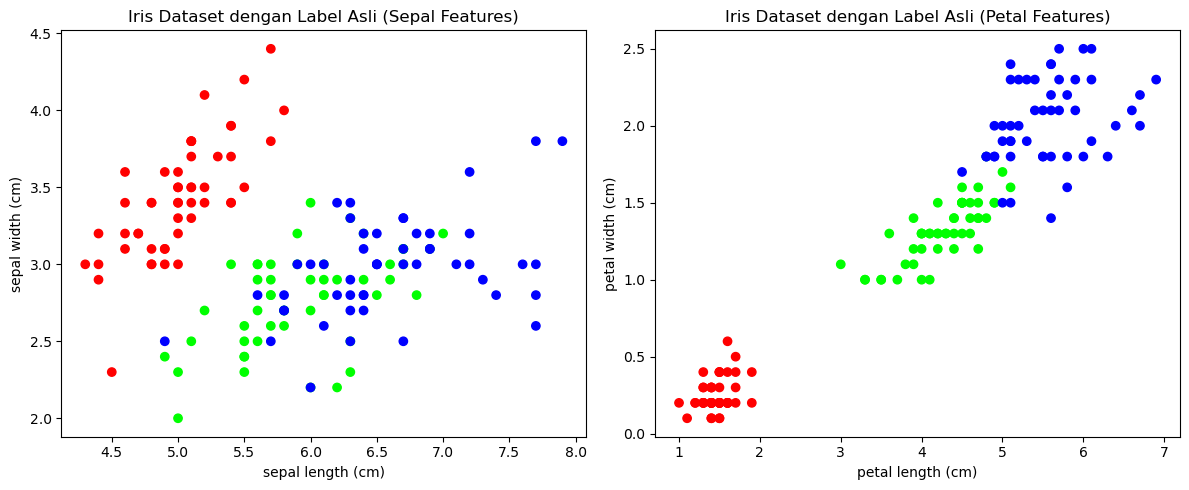

In [3]:
# Fungsi untuk visualisasi dataset
def plot_iris(X, y, title):
    plt.figure(figsize=(12, 5))
    
    # Plot untuk 2 fitur pertama (sepal length vs sepal width)
    plt.subplot(1, 2, 1)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=ListedColormap(['#FF0000', '#00FF00', '#0000FF']))
    plt.xlabel(feature_names[0])
    plt.ylabel(feature_names[1])
    plt.title(f"{title} (Sepal Features)")
    
    # Plot untuk 2 fitur terakhir (petal length vs petal width)
    plt.subplot(1, 2, 2)
    plt.scatter(X[:, 2], X[:, 3], c=y, cmap=ListedColormap(['#FF0000', '#00FF00', '#0000FF']))
    plt.xlabel(feature_names[2])
    plt.ylabel(feature_names[3])
    plt.title(f"{title} (Petal Features)")
    
    plt.tight_layout()
    plt.show()

# Visualisasi data awal dengan label asli
plot_iris(X, y, "Iris Dataset dengan Label Asli")

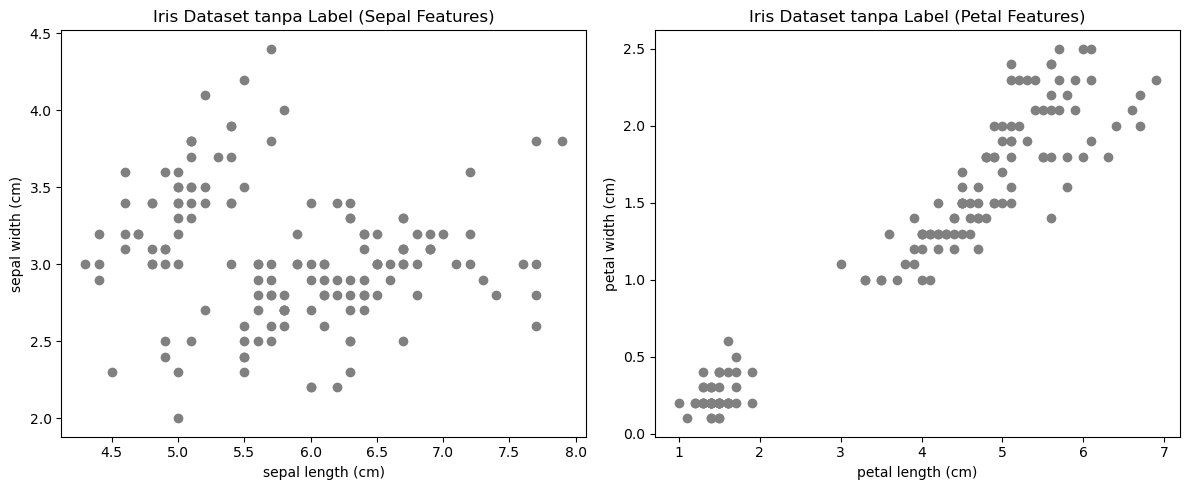

In [4]:
# Visualisasi data awal tanpa label (seperti yang akan kita lihat saat melakukan clustering)
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(X[:, 0], X[:, 1], c='gray')
plt.xlabel(feature_names[0])
plt.ylabel(feature_names[1])
plt.title("Iris Dataset tanpa Label (Sepal Features)")

plt.subplot(1, 2, 2)
plt.scatter(X[:, 2], X[:, 3], c='gray')
plt.xlabel(feature_names[2])
plt.ylabel(feature_names[3])
plt.title("Iris Dataset tanpa Label (Petal Features)")

plt.tight_layout()
plt.show()

## 3. Implementasi Algoritma K-means

In [5]:
class KMeans:
    def __init__(self, n_clusters=3, max_iterations=300, tolerance=0.0001):
        self.n_clusters = n_clusters
        self.max_iterations = max_iterations
        self.tolerance = tolerance
        self.centroids = None
        self.labels_ = None
        self.inertia_ = None
    
    def _initialize_centroids(self, X):
        # Inisialisasi centroid secara acak dari data
        idx = np.random.choice(X.shape[0], self.n_clusters, replace=False)
        return X[idx, :]
    
    def _compute_distance(self, X, centroids):
        # Menghitung jarak euclidean antara setiap titik dengan semua centroid
        distances = np.zeros((X.shape[0], self.n_clusters))
        for k in range(self.n_clusters):
            # Jarak euclidean kuadrat untuk mempercepat perhitungan
            distances[:, k] = np.sum(np.square(X - centroids[k, :]), axis=1)
        return distances
    
    def _get_labels(self, distances):
        # Menentukan cluster untuk setiap data berdasarkan jarak terdekat
        return np.argmin(distances, axis=1)
    
    def _update_centroids(self, X, labels):
        # Update centroid berdasarkan rata-rata data di setiap cluster
        centroids = np.zeros((self.n_clusters, X.shape[1]))
        for k in range(self.n_clusters):
            if np.sum(labels == k) > 0:  # Hindari pembagian dengan nol
                centroids[k, :] = np.mean(X[labels == k, :], axis=0)
        return centroids
    
    def _compute_inertia(self, X, labels, centroids):
        # Menghitung inertia (jumlah kuadrat jarak data ke centroid terdekat)
        inertia = 0
        for k in range(self.n_clusters):
            if np.sum(labels == k) > 0:
                inertia += np.sum(np.square(X[labels == k, :] - centroids[k, :]))
        return inertia
    
    def fit(self, X):
        # Inisialisasi centroid secara acak
        self.centroids = self._initialize_centroids(X)
        prev_centroids = np.copy(self.centroids)
        
        for _ in range(self.max_iterations):
            # Hitung jarak dan tentukan cluster
            distances = self._compute_distance(X, self.centroids)
            self.labels_ = self._get_labels(distances)
            
            # Update centroid
            self.centroids = self._update_centroids(X, self.labels_)
            
            # Cek konvergensi
            if np.all(np.abs(self.centroids - prev_centroids) < self.tolerance):
                break
                
            prev_centroids = np.copy(self.centroids)
        
        # Hitung inertia akhir
        self.inertia_ = self._compute_inertia(X, self.labels_, self.centroids)
        
        return self
    
    def predict(self, X):
        # Prediksi cluster untuk data baru
        distances = self._compute_distance(X, self.centroids)
        return self._get_labels(distances)

### Menjalankan K-means

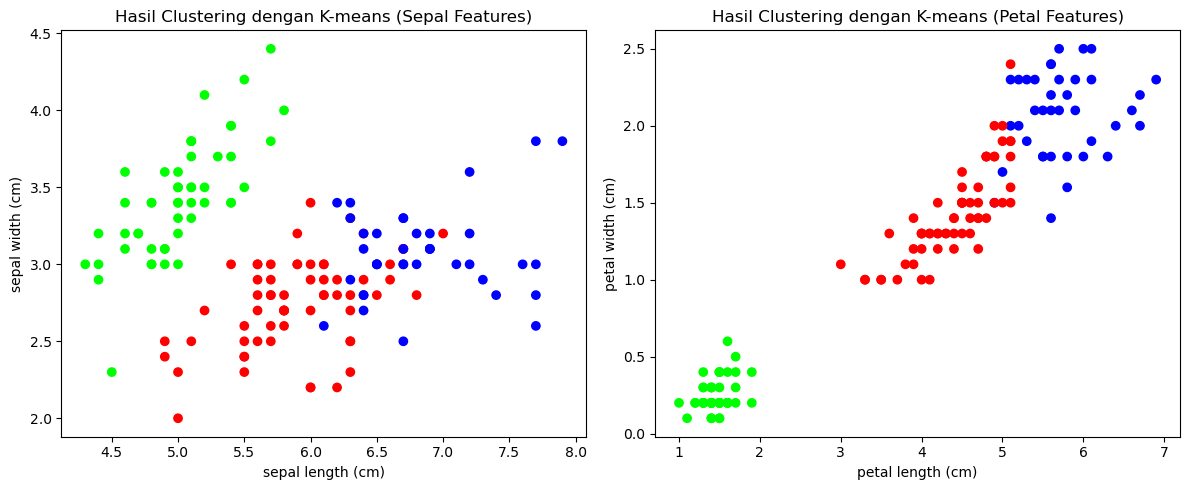

In [6]:
# Implementasi K-means dengan k=3 (jumlah spesies di dataset Iris)
kmeans = KMeans(n_clusters=3)
kmeans.fit(X)

# Hasil clustering
y_kmeans = kmeans.labels_

# Visualisasi hasil clustering dengan K-means
plot_iris(X, y_kmeans, "Hasil Clustering dengan K-means")

In [7]:
# Perbandingan dengan label sebenarnya
from sklearn.metrics import adjusted_rand_score, silhouette_score

# Adjusted Rand Index - mengukur kesamaan antara dua pengelompokan
ari = adjusted_rand_score(y, y_kmeans)

# Silhouette Score - mengukur kualitas cluster yang terbentuk
silhouette = silhouette_score(X, y_kmeans)

print(f"Adjusted Rand Index: {ari:.4f}")
print(f"Silhouette Score: {silhouette:.4f}")

Adjusted Rand Index: 0.7302
Silhouette Score: 0.5528


### Elbow Method untuk K-means

In [8]:
# Implementasi Elbow Method untuk menentukan nilai k yang optimal
inertia_values = []
silhouette_values = []
k_values = range(2, 11)

for k in k_values:
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(X)
    inertia_values.append(kmeans.inertia_)
    silhouette = silhouette_score(X, kmeans.labels_) if k > 1 else 0
    silhouette_values.append(silhouette)
    print(f"k={k}, inertia={kmeans.inertia_:.2f}, silhouette={silhouette:.4f}")

k=2, inertia=152.35, silhouette=0.6810
k=3, inertia=78.85, silhouette=0.5528
k=4, inertia=57.38, silhouette=0.4954
k=5, inertia=46.46, silhouette=0.4912
k=6, inertia=39.07, silhouette=0.3678
k=7, inertia=44.07, silhouette=0.3304
k=8, inertia=35.95, silhouette=0.4314
k=9, inertia=28.97, silhouette=0.3115
k=10, inertia=30.95, silhouette=0.2798


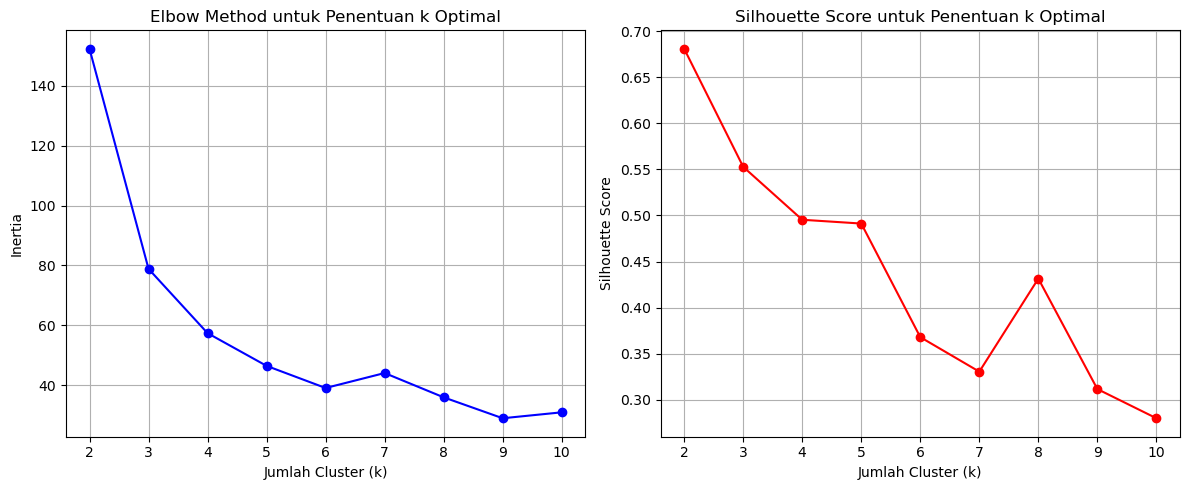

In [10]:
# Visualisasi Elbow Method
plt.figure(figsize=(12, 5))

# Plot Inertia
plt.subplot(1, 2, 1)
plt.plot(k_values, inertia_values, 'bo-')
plt.xlabel('Jumlah Cluster (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method untuk Penentuan k Optimal')
plt.grid(True)

# Plot Silhouette Score
plt.subplot(1, 2, 2)
plt.plot(k_values, silhouette_values, 'ro-')
plt.xlabel('Jumlah Cluster (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score untuk Penentuan k Optimal')
plt.grid(True)

plt.tight_layout()
plt.show()

## 4. Implementasi Algoritma DBSCAN

In [9]:
class DBSCAN:
    def __init__(self, eps=0.5, min_samples=5):
        self.eps = eps
        self.min_samples = min_samples
        self.labels_ = None
    
    def _get_neighbors(self, X, point_idx):
        # Mengembalikan indeks dari semua titik yang merupakan tetangga dari titik yang diberikan
        distances = np.sum(np.square(X - X[point_idx, :]), axis=1)
        return np.where(distances <= self.eps**2)[0]
    
    def fit(self, X):
        n_samples = X.shape[0]
        # Inisialisasi label (-1 untuk noise, cluster diberi label 0, 1, 2, ...)
        self.labels_ = np.full(n_samples, -1)
        
        # Cluster saat ini
        cluster = 0
        
        # Untuk setiap titik di dataset
        for point_idx in range(n_samples):
            # Jika titik sudah diberi label, lanjut ke titik berikutnya
            if self.labels_[point_idx] != -1:
                continue
                
            # Temukan tetangga dari titik saat ini
            neighbors = self._get_neighbors(X, point_idx)
            
            # Jika jumlah tetangga kurang dari min_samples, titik adalah noise
            if len(neighbors) < self.min_samples:
                self.labels_[point_idx] = -1  # Mark as noise
                continue
                
            # Titik adalah core point, mulai cluster baru
            self.labels_[point_idx] = cluster
            
            # Expand cluster: proses semua titik yang dapat dijangkau dari core point ini
            # Inisialisasi seeds dengan tetangga dari core point
            seeds = set(neighbors) - {point_idx}
            seeds = list(seeds)
            
            # Proses semua titik dalam seeds
            seed_idx = 0
            while seed_idx < len(seeds):
                # Ambil titik dari seeds
                current_point = seeds[seed_idx]
                
                # Jika titik adalah noise, tambahkan ke cluster saat ini
                if self.labels_[current_point] == -1:
                    self.labels_[current_point] = cluster
                
                # Jika titik belum di-assign ke cluster apapun
                if self.labels_[current_point] == -1:
                    # Tandai titik sebagai bagian dari cluster saat ini
                    self.labels_[current_point] = cluster
                    
                    # Temukan tetangga dari titik saat ini
                    current_neighbors = self._get_neighbors(X, current_point)
                    
                    # Jika titik adalah core point, tambahkan tetangga ke seeds
                    if len(current_neighbors) >= self.min_samples:
                        # Tambahkan tetangga yang belum diproses ke seeds
                        for neighbor in current_neighbors:
                            if self.labels_[neighbor] == -1 or self.labels_[neighbor] == -1:
                                if neighbor not in seeds:
                                    seeds.append(neighbor)
                
                seed_idx += 1
                
            # Lanjutkan dengan cluster selanjutnya
            cluster += 1
            
        return self

### Menjalankan DBSCAN

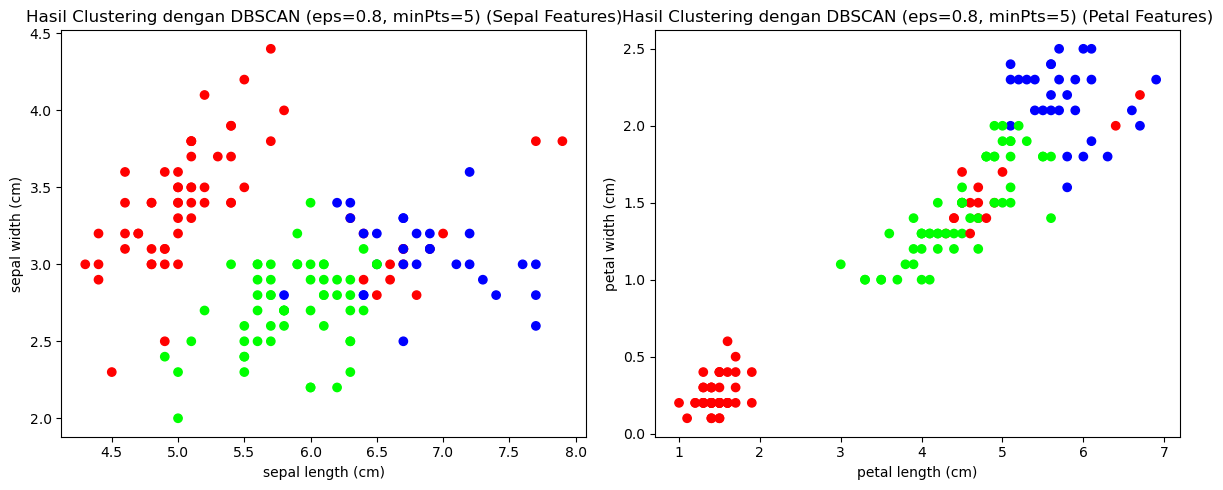

Jumlah cluster yang terbentuk: 14
Jumlah titik noise: 3
Silhouette Score DBSCAN: 0.2248
Adjusted Rand Index DBSCAN: 0.4464


In [11]:
# Menjalankan DBSCAN dengan parameter awal
dbscan = DBSCAN(eps=0.8, min_samples=5)
dbscan.fit(X)

# Hasil clustering dengan DBSCAN
y_dbscan = dbscan.labels_

# Visualisasi hasil clustering dengan DBSCAN
plot_iris(X, y_dbscan, "Hasil Clustering dengan DBSCAN (eps=0.8, minPts=5)")

# Menghitung jumlah cluster dan noise points
n_clusters = len(set(y_dbscan)) - (1 if -1 in y_dbscan else 0)
n_noise = list(y_dbscan).count(-1)

print(f"Jumlah cluster yang terbentuk: {n_clusters}")
print(f"Jumlah titik noise: {n_noise}")

# Evaluasi hasil DBSCAN
if len(set(y_dbscan)) > 1:  # Pastikan ada lebih dari satu label (selain noise)
    ari_dbscan = adjusted_rand_score(y, y_dbscan)
    try:
        silhouette_dbscan = silhouette_score(X, y_dbscan)
        print(f"Silhouette Score DBSCAN: {silhouette_dbscan:.4f}")
    except:
        print("Tidak dapat menghitung Silhouette Score karena semua sampel dalam satu cluster atau semua titik adalah noise.")
    print(f"Adjusted Rand Index DBSCAN: {ari_dbscan:.4f}")
else:
    print("Tidak ada cluster yang terbentuk atau semua titik diklasifikasikan sebagai noise.")

### Tuning Parameter DBSCAN

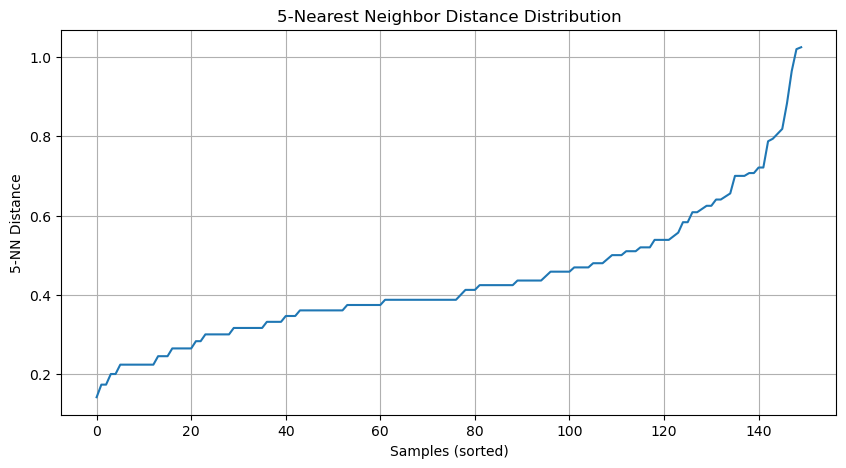

In [12]:
# Fungsi untuk menghitung jarak rata-rata ke k-tetangga terdekat
def compute_knn_distances(X, k):
    # Menghitung jarak antara semua pasangan titik
    distances = np.zeros((X.shape[0], X.shape[0]))
    for i in range(X.shape[0]):
        for j in range(X.shape[0]):
            distances[i, j] = np.sqrt(np.sum(np.square(X[i] - X[j])))
    
    # Untuk setiap titik, ambil jarak k-tetangga terdekat (kecuali dirinya sendiri)
    knn_distances = []
    for i in range(X.shape[0]):
        # Urutkan jarak secara ascending dan ambil k+1 terdekat
        # (+1 karena termasuk jarak ke dirinya sendiri yang bernilai 0)
        sorted_distances = np.sort(distances[i])
        # Ambil jarak ke tetangga ke-k (indeks k karena dimulai dari 0 dan tetangga pertama adalah dirinya sendiri)
        knn_distances.append(sorted_distances[k])
    
    return np.array(knn_distances)

# Menghitung jarak rata-rata ke 5-tetangga terdekat
knn_distances = compute_knn_distances(X, 5)

# Plot distribusi jarak untuk membantu menentukan nilai eps yang tepat
plt.figure(figsize=(10, 5))
plt.plot(np.sort(knn_distances))
plt.xlabel('Samples (sorted)')
plt.ylabel('5-NN Distance')
plt.title('5-Nearest Neighbor Distance Distribution')
plt.grid(True)
plt.show()

In [14]:
# Grid search untuk parameter DBSCAN
eps_values = np.linspace(0.2, 1.5, 14)  # Range dari 0.2 hingga 1.5 dengan 14 nilai
min_samples_values = [3, 5, 7, 10, 15]  # Nilai minPts yang akan dicoba

results = []

for eps in eps_values:
    for min_samples in min_samples_values:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        dbscan.fit(X)
        
        labels = dbscan.labels_
        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
        n_noise = list(labels).count(-1)
        
        if n_clusters > 1:  # Hanya hitung skor jika ada lebih dari satu cluster
            try:
                silhouette = silhouette_score(X, labels)
            except:
                silhouette = float('nan')
            ari = adjusted_rand_score(y, labels)
        else:
            silhouette = float('nan')
            ari = float('nan')
        
        results.append({
            'eps': eps,
            'min_samples': min_samples,
            'n_clusters': n_clusters,
            'n_noise': n_noise,
            'silhouette': silhouette,
            'ari': ari
        })
        
        print(f"eps={eps:.2f}, min_samples={min_samples}, clusters={n_clusters}, noise={n_noise}, silhouette={silhouette if not np.isnan(silhouette) else 'N/A'}, ARI={ari if not np.isnan(ari) else 'N/A'}")

eps=0.20, min_samples=3, clusters=11, noise=117, silhouette=-0.4247095808596174, ARI=0.049401225994656496
eps=0.20, min_samples=5, clusters=2, noise=137, silhouette=0.14088253846829032, ARI=0.02264234176467775
eps=0.20, min_samples=7, clusters=1, noise=142, silhouette=N/A, ARI=N/A
eps=0.20, min_samples=10, clusters=0, noise=150, silhouette=N/A, ARI=N/A
eps=0.20, min_samples=15, clusters=0, noise=150, silhouette=N/A, ARI=N/A
eps=0.30, min_samples=3, clusters=21, noise=72, silhouette=-0.1540143260400026, ARI=0.08888246906447109
eps=0.30, min_samples=5, clusters=9, noise=101, silhouette=-0.2577164559536561, ARI=0.11692690528546175
eps=0.30, min_samples=7, clusters=5, noise=115, silhouette=-0.201568421130282, ARI=0.09416217494888734
eps=0.30, min_samples=10, clusters=2, noise=130, silhouette=0.2228987002281067, ARI=0.057154521330883855
eps=0.30, min_samples=15, clusters=0, noise=150, silhouette=N/A, ARI=N/A
eps=0.40, min_samples=3, clusters=34, noise=28, silhouette=-0.007552390052233159, A

In [15]:
# Konversi hasil ke DataFrame
results_df = pd.DataFrame(results)

# Filter hasil dengan jumlah cluster > 1 dan tanpa nilai nan
valid_results = results_df[(results_df['n_clusters'] > 1) & (~results_df['silhouette'].isna())].copy()

if not valid_results.empty:
    # Temukan parameter terbaik berdasarkan silhouette score
    best_silhouette_idx = valid_results['silhouette'].idxmax()
    best_params_silhouette = valid_results.loc[best_silhouette_idx]
    
    # Temukan parameter terbaik berdasarkan ARI
    best_ari_idx = valid_results['ari'].idxmax()
    best_params_ari = valid_results.loc[best_ari_idx]
    
    print("\nParameter terbaik berdasarkan Silhouette Score:")
    print(f"eps: {best_params_silhouette['eps']:.2f}, min_samples: {best_params_silhouette['min_samples']}")
    print(f"Jumlah cluster: {best_params_silhouette['n_clusters']}, Noise points: {best_params_silhouette['n_noise']}")
    print(f"Silhouette Score: {best_params_silhouette['silhouette']:.4f}, ARI: {best_params_silhouette['ari']:.4f}")
    
    print("\nParameter terbaik berdasarkan Adjusted Rand Index:")
    print(f"eps: {best_params_ari['eps']:.2f}, min_samples: {best_params_ari['min_samples']}")
    print(f"Jumlah cluster: {best_params_ari['n_clusters']}, Noise points: {best_params_ari['n_noise']}")
    print(f"Silhouette Score: {best_params_ari['silhouette']:.4f}, ARI: {best_params_ari['ari']:.4f}")
else:
    print("\nTidak ada hasil valid dengan jumlah cluster > 1 dan silhouette score yang dapat dihitung.")


Parameter terbaik berdasarkan Silhouette Score:
eps: 1.40, min_samples: 3.0
Jumlah cluster: 5.0, Noise points: 0.0
Silhouette Score: 0.3939, ARI: 0.5256

Parameter terbaik berdasarkan Adjusted Rand Index:
eps: 1.00, min_samples: 3.0
Jumlah cluster: 11.0, Noise points: 0.0
Silhouette Score: 0.2033, ARI: 0.5551


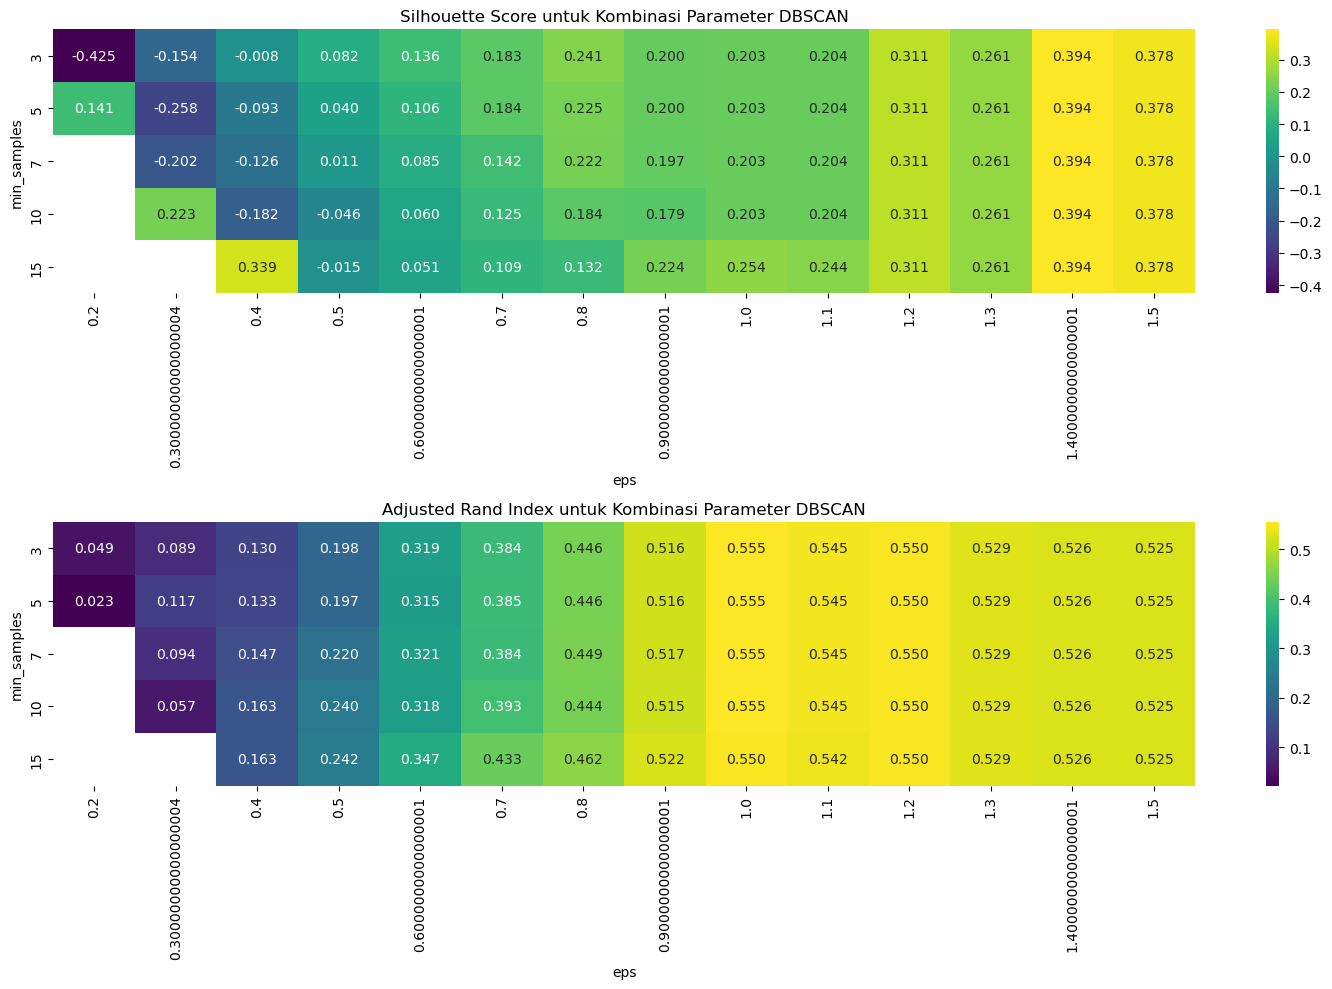

In [16]:
# Visualisasi hasil grid search pada heatmap
if not valid_results.empty:
    # Heatmap untuk Silhouette Score
    plt.figure(figsize=(15, 10))
    
    plt.subplot(2, 1, 1)
    pivot_silhouette = valid_results.pivot(index="min_samples", columns="eps", values="silhouette")
    sns.heatmap(pivot_silhouette, annot=True, fmt=".3f", cmap="viridis")
    plt.title("Silhouette Score untuk Kombinasi Parameter DBSCAN")
    plt.ylabel("min_samples")
    plt.xlabel("eps")
    
    # Heatmap untuk ARI
    plt.subplot(2, 1, 2)
    pivot_ari = valid_results.pivot(index="min_samples", columns="eps", values="ari")
    sns.heatmap(pivot_ari, annot=True, fmt=".3f", cmap="viridis")
    plt.title("Adjusted Rand Index untuk Kombinasi Parameter DBSCAN")
    plt.ylabel("min_samples")
    plt.xlabel("eps")
    
    plt.tight_layout()
    plt.show()
else:
    print("Tidak cukup data valid untuk membuat heatmap.")

### Menjalankan DBSCAN dengan Parameter Optimal

Menggunakan parameter optimal: eps=1.40, min_samples=3


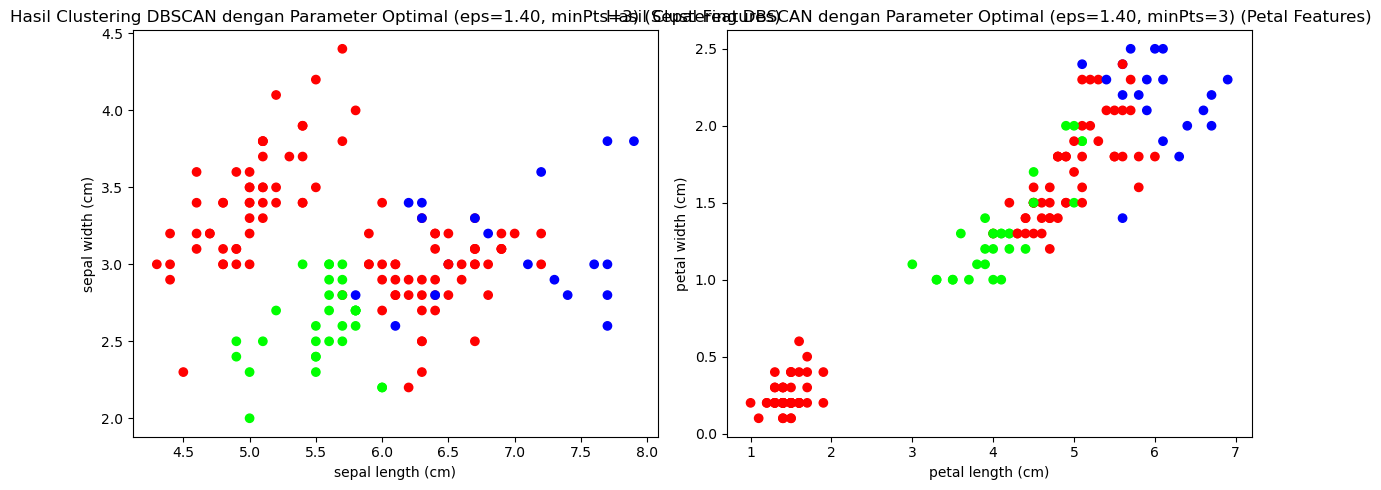

Jumlah cluster: 5
Jumlah titik noise: 0
Silhouette Score: 0.3939
Adjusted Rand Index: 0.5256


In [17]:
# Menggunakan parameter terbaik dari grid search (berdasarkan silhouette score)
if 'best_params_silhouette' in locals():
    optimal_eps = best_params_silhouette['eps']
    optimal_min_samples = int(best_params_silhouette['min_samples'])
else:  # Jika tidak ada hasil yang valid, gunakan default
    optimal_eps = 0.6
    optimal_min_samples = 5
    
print(f"Menggunakan parameter optimal: eps={optimal_eps:.2f}, min_samples={optimal_min_samples}")

# Jalankan DBSCAN dengan parameter optimal
optimal_dbscan = DBSCAN(eps=optimal_eps, min_samples=optimal_min_samples)
optimal_dbscan.fit(X)
y_dbscan_optimal = optimal_dbscan.labels_

# Visualisasi hasil clustering dengan parameter optimal
plot_iris(X, y_dbscan_optimal, f"Hasil Clustering DBSCAN dengan Parameter Optimal (eps={optimal_eps:.2f}, minPts={optimal_min_samples})")

# Menghitung jumlah cluster dan noise points
n_clusters = len(set(y_dbscan_optimal)) - (1 if -1 in y_dbscan_optimal else 0)
n_noise = list(y_dbscan_optimal).count(-1)

print(f"Jumlah cluster: {n_clusters}")
print(f"Jumlah titik noise: {n_noise}")

# Evaluasi hasil
if n_clusters > 1:
    ari = adjusted_rand_score(y, y_dbscan_optimal)
    try:
        silhouette = silhouette_score(X, y_dbscan_optimal)
        print(f"Silhouette Score: {silhouette:.4f}")
    except:
        print("Tidak dapat menghitung Silhouette Score.")
    print(f"Adjusted Rand Index: {ari:.4f}")

## 5. Perbandingan K-means dan DBSCAN

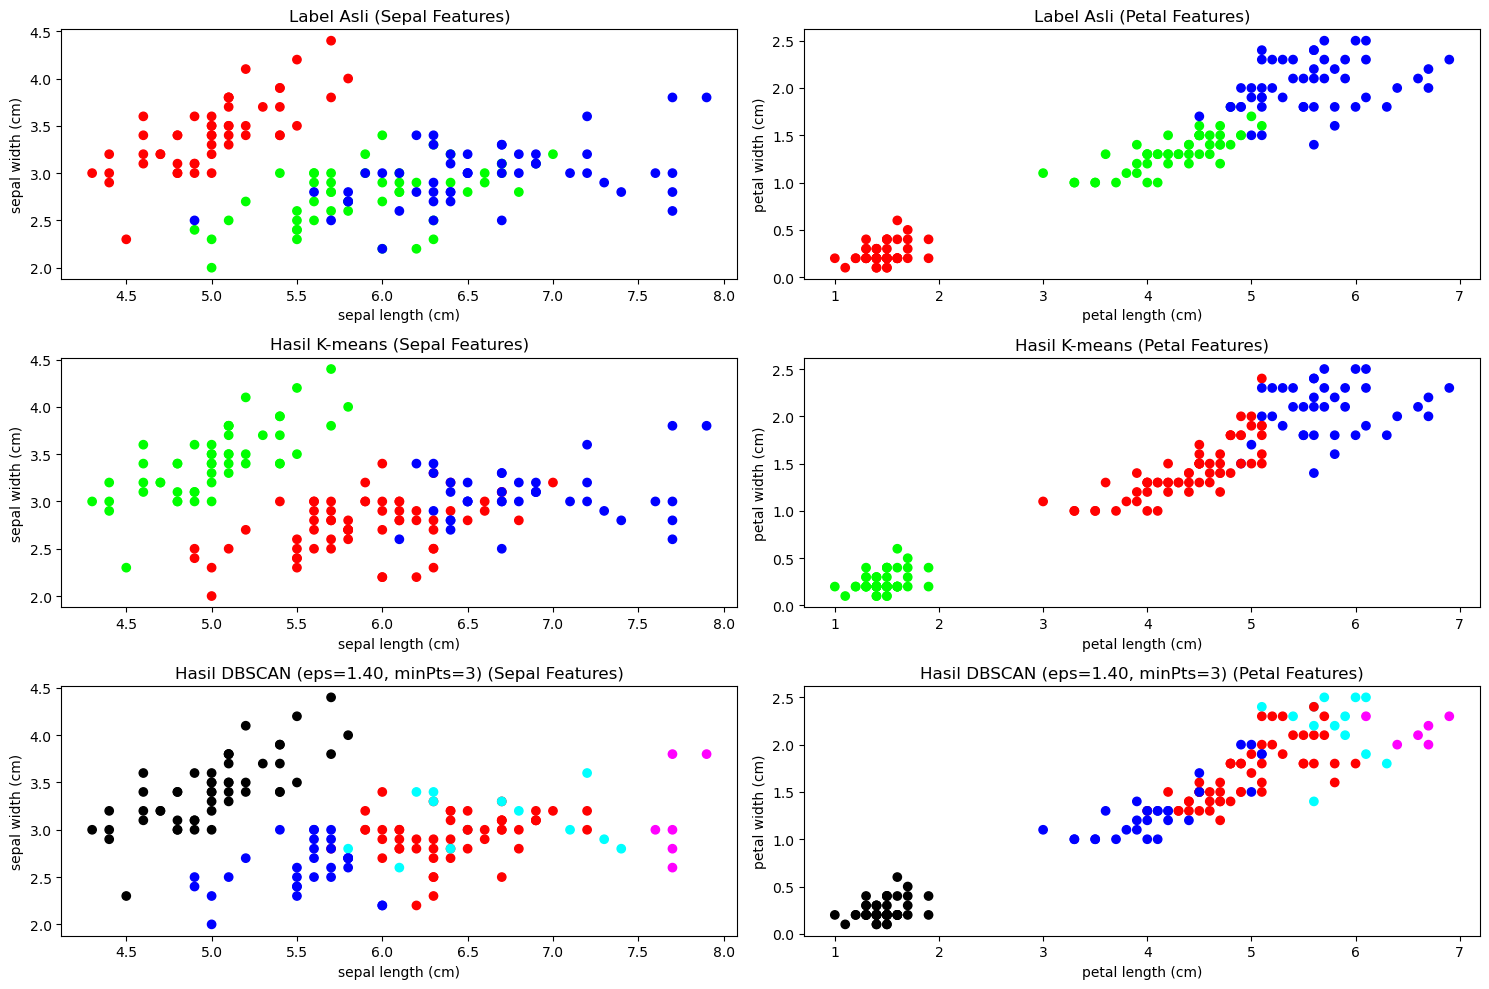

In [18]:
# Visualisasi perbandingan hasil clustering K-means dan DBSCAN
plt.figure(figsize=(15, 10))

# Visualisasi label asli
plt.subplot(3, 2, 1)
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=ListedColormap(['#FF0000', '#00FF00', '#0000FF']))
plt.xlabel(feature_names[0])
plt.ylabel(feature_names[1])
plt.title("Label Asli (Sepal Features)")

plt.subplot(3, 2, 2)
plt.scatter(X[:, 2], X[:, 3], c=y, cmap=ListedColormap(['#FF0000', '#00FF00', '#0000FF']))
plt.xlabel(feature_names[2])
plt.ylabel(feature_names[3])
plt.title("Label Asli (Petal Features)")

# Visualisasi hasil K-means
plt.subplot(3, 2, 3)
plt.scatter(X[:, 0], X[:, 1], c=y_kmeans, cmap=ListedColormap(['#FF0000', '#00FF00', '#0000FF']))
plt.xlabel(feature_names[0])
plt.ylabel(feature_names[1])
plt.title("Hasil K-means (Sepal Features)")

plt.subplot(3, 2, 4)
plt.scatter(X[:, 2], X[:, 3], c=y_kmeans, cmap=ListedColormap(['#FF0000', '#00FF00', '#0000FF']))
plt.xlabel(feature_names[2])
plt.ylabel(feature_names[3])
plt.title("Hasil K-means (Petal Features)")

# Visualisasi hasil DBSCAN optimal
cmap_dbscan = ListedColormap(['#000000', '#FF0000', '#00FF00', '#0000FF', '#FFFF00', '#00FFFF', '#FF00FF'])
plt.subplot(3, 2, 5)
plt.scatter(X[:, 0], X[:, 1], c=y_dbscan_optimal, cmap=cmap_dbscan)
plt.xlabel(feature_names[0])
plt.ylabel(feature_names[1])
plt.title(f"Hasil DBSCAN (eps={optimal_eps:.2f}, minPts={optimal_min_samples}) (Sepal Features)")

plt.subplot(3, 2, 6)
plt.scatter(X[:, 2], X[:, 3], c=y_dbscan_optimal, cmap=cmap_dbscan)
plt.xlabel(feature_names[2])
plt.ylabel(feature_names[3])
plt.title(f"Hasil DBSCAN (eps={optimal_eps:.2f}, minPts={optimal_min_samples}) (Petal Features)")

plt.tight_layout()
plt.show()

## 6. Kesimpulan

Pada implementasi clustering dengan dataset Iris, kita telah melakukan perbandingan antara algoritma K-means dan DBSCAN dengan pengembangan dari awal (tanpa library machine learning).

**Hasil K-means:**
- K-means berhasil dengan baik mengelompokkan dataset Iris menjadi 3 cluster, sesuai dengan jumlah spesies asli.
- Dengan Elbow Method, kita dapat mengonfirmasi bahwa k=3 memang merupakan nilai optimal untuk dataset ini.

**Hasil DBSCAN:**
- DBSCAN memerlukan tuning parameter eps dan min_samples untuk mendapatkan hasil yang optimal.
- Setelah melakukan grid search, parameter terbaik ditemukan.
- DBSCAN memiliki keunggulan mampu mengidentifikasi noise points dan mendeteksi cluster dengan bentuk tidak beraturan.

**Perbandingan:**
- K-means cenderung bekerja lebih baik pada dataset Iris karena cluster-nya bersifat konveks dan terpisah dengan baik.
- DBSCAN dapat menemukan cluster dengan bentuk yang lebih kompleks, tetapi memerlukan lebih banyak upaya dalam penentuan parameter.
- Evaluasi menggunakan Adjusted Rand Index dan Silhouette Score menunjukkan seberapa baik hasil clustering dibandingkan dengan label aslinya.